# Identifying Pneumonia with Deep Learning
***
Author: Andre Layton
***

# Overview
.......

# Business Problem
........

***
<img src="https://media.licdn.com/dms/image/D4D12AQEqfniioS4KVQ/article-cover_image-shrink_720_1280/0/1677311223167?e=2147483647&v=beta&t=loMCjRjjqYyKI72mjdbVk5_XbxRdzonIKz0qRn-BcXo" style="height:500px; width:875px" />

In [8]:
from tensorflow.keras.utils import get_file
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data_dir = 'data/chest_xray/train'
test_data_dir = 'data/chest_xray/test'
validation_dir = 'data/chest_xray/val'

train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(64, 64), batch_size=5216)
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(64, 64), batch_size=624)
val_generator = ImageDataGenerator().flow_from_directory(validation_dir, target_size=(64, 64), batch_size=16)

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


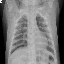

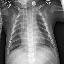

In [5]:
display(array_to_img(train_images[17]))
array_to_img(train_images[4200])

In [13]:
print("Train Shape:")
print(np.shape(train_images))
print(np.shape(train_labels))
print("\nTest Shape:")
print(np.shape(test_images))
print(np.shape(test_labels))
print("\nValidation Shape:")
print(np.shape(val_images))
print(np.shape(val_labels))

Train Shape:
(5216, 64, 64, 3)
(5216, 2)

Test Shape:
(624, 64, 64, 3)
(624, 2)

Validation Shape:
(16, 64, 64, 3)
(16, 2)
